**Project Description:**
We will analyze data on reported incidents of UFO sightings. Utilizing data collected by an organization dedicated to this topic, we will apply topic clustering techniques to identify commonalities among these sightings and interpret the results to provide a summary of the major themes of these reports. After clustering among the full dataset, we will then focus on comparing UFO sightings in California, Arizona, and Nevada again using clustering to investigate their similarities and differences.  

**Analysis: **
We will perform topic clustering on the text column from our dataset to identify major topics of discussion. We will then use this clustering to analyze any commonalities or anomalies based on descriptors of UFO shape, size, etc. We’ll start with a cluster analysis of the full dataset, and then narrow the focus to comparing sightings exclusively in California, Nevada, and Arizona.

**Deliverables: **
We will provide the following deliverables at the end of the project:
A dataset containing reports of UFO sightings
A set of insights derived from the dataset
A short in-class presentation of our findings, discussions of their meaning, and general “lessons learned” from our project. 


# Packages and Installations:

In [48]:
#installs any packages not available by default
!pip install gensim
!pip install wordcloud
%time

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Wall time: 0 ns


You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [49]:
#importing packages neeeded for Text Analysis
import pandas as pd
import numpy as np
import nltk
import sklearn
import gensim
import re
import string
import wordcloud
import os
import pylab as pl

%time

Wall time: 0 ns


In [50]:
##Specific Text Mining Features from SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
#Other specific useful packages
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import matplotlib as mpl
%time

Wall time: 0 ns


In [51]:
#Downloading features from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
%time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Wall time: 0 ns


# User Defined Functions:

In [52]:
#Flatten Function (This will collapse a list of lists into just one list)
flatten = lambda l: [item for sublist in l for item in sublist]

In [53]:
#Unicoder

def Unicoder(list):
  new_list = []
  for i in list:
    new = str(i)
    new.encode('utf-8')
    new_list.append(new)
  return(new_list)


In [54]:
#Stringer

def Stringer(list):
  new_list = []
  for i in list:
    new = str(i)
    new_list.append(new)
  return(new_list)

In [55]:
#StringOnly

def StringOnly(list):
  new_list = []
  for i in list:
    if isinstance(i, str):
        new_list.append(i)
  return(new_list)

In [56]:
#Term Vector Function
def Term_Vectors(doc):
  punc = re.compile( '[%s]' % re.escape( string.punctuation ) )
  term_vec = [ ]

  for d in doc:
      d = str(d)
      d = d.lower()
      d = punc.sub( '', d )
      term_vec.append( nltk.word_tokenize( d ) )

  return(term_vec)
     

In [57]:
#Stop Word Function
def Stop_Word(term_vec, stop_words = nltk.corpus.stopwords.words( 'english' )):

  for i in range( 0, len( term_vec ) ):
      
      term_list = [ ]

      for term in term_vec[i]:
          if term not in stop_words:
              term_list.append( term )

      term_vec[i] = term_list

  return(term_vec)

In [58]:
#Porter Stem Function - Lemmatizer was better

def Porter_Stem(term_vec):
  porter = nltk.stem.porter.PorterStemmer()

  for i in range( 0, len( term_vec ) ):
    for j in range( 0, len( term_vec[ i ] ) ):
      term_vec[ i ][ j ] = porter.stem( term_vec[ i ][ j ] )

  return(term_vec)


In [59]:
#Lemmatizer Function
def lemmatizer(term_vec):
  for i in range( 0, len( term_vec ) ):
    for j in range( 0, len( term_vec[ i ] ) ):
      try: pos = str(wn.synsets(j)[0].pos())
      except: pos = "n"
      term_vec[i][j] = str(WordNetLemmatizer().lemmatize(term_vec[i][j],pos))
  return(term_vec)
      


In [60]:
##Basic Word Cloud Function

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


In [62]:
def stateshape(list):
  
  shapelist = []
  
  state_shapes = {"CA": 'o',
                  "NV": 'v', 
                  "AR": '^', 
                  "NM": "<", 
                  "NC": ">"}
  
  for i in list:
    shapelist.append(state_shapes[i])

  return(shapelist)

# Initial Data Importation and Cleaning:

In [63]:
#imports ufo dataset from our data.world repo
ufoset = pd.read_csv('https://query.data.world/s/t5l7slkbhurybmuxkfgncobbaknf7i')
%time

Wall time: 0 ns


In [64]:
#subsets data by selected states, removes every column but State and Text

## ALTER FOR DIFFERENT STATES HERE ##
states = ["CA","NV","AR","NM", "NC"]
subset_ufoset = ufoset.loc[ufoset['state'].isin(states)]

encounters = subset_ufoset[['text','state']]

#Word Vectors
SelectStates_Xvect = encounters['text'].values.tolist()
SelectStates_Svect = encounters['state'].values.tolist()


shapes = stateshape(encounters['state'].values.tolist())

print("Lists created.")
%time

Lists created.
Wall time: 0 ns


In [65]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(SelectStates_Xvect)):
    ranks.append(i)

print("Rank Index Created")
%time


Rank Index Created
Wall time: 0 ns


# Begin Text Processing with Term Vectors, Stopwords, and Stemming:

In [66]:
#Creates Term Vectors for all word vectors

SelectStates_term = Term_Vectors(SelectStates_Xvect)

print("Term Vectors  Complete.")
%time

Term Vectors  Complete.
Wall time: 0 ns


In [67]:
stopword = nltk.corpus.stopwords.words('english')
custom_words = ['summary','SUMMARY',"'","-","saw", "like", "see", "could", "looked", "seen", "foot", "would"]
stopword += custom_words

print("Stop Words Created.")
%time

Stop Words Created.
Wall time: 0 ns


In [68]:
#Stop Word filter for all Vectors

SelectStates_stop = Stop_Word(SelectStates_term,stopword)

print("Stop Words filter Applied to Term Vectors.")
%time

Stop Words filter Applied to Term Vectors.
Wall time: 0 ns


In [69]:
#Lemmatizing for All Vectors
#Results look way cleaner than porter stemming

SelectStates_lem = lemmatizer(SelectStates_stop)

print("Lemmatization Complete.")
%time

Lemmatization Complete.
Wall time: 0 ns


In [70]:
allwords_tokens = flatten(SelectStates_stop)
allwords_stemmed = flatten(SelectStates_lem)

vocab_frame = pd.DataFrame({'words': allwords_tokens}, index = allwords_stemmed)

print("Vocab Vector Complete")
%time

Vocab Vector Complete
Wall time: 0 ns


# tfidf Vectorization & K-Means Clustering

In [71]:
#TFIDF
SelectStates_tfidf = TfidfVectorizer(SelectStates_lem, decode_error = "replace", max_features = 200000, max_df = 0.90, min_df = 0.10)



print("Tfidf Vectors Complete.")
%time


Tfidf Vectors Complete.
Wall time: 0 ns


In [72]:
##Document Similarity Matrices

#Converts Items into Unicode
SelectStates_Uni = Unicoder(SelectStates_lem)

#Creates Similarity Matrix
SelectStates_matrix = SelectStates_tfidf.fit_transform(SelectStates_Uni)


print("Similarity Matrices Complete.")
%time


Similarity Matrices Complete.
Wall time: 0 ns


In [73]:
#Get term names

select_terms = SelectStates_tfidf.get_feature_names()

print("Term Names Complete.")
%time

Term Names Complete.
Wall time: 0 ns


In [74]:
#Pairwise Similaritiy Distances Calculation

SelectStates_dist = 1 - cosine_similarity(SelectStates_matrix)

print("Pairwise Complete Distances Calculated")
%time

Pairwise Complete Distances Calculated
Wall time: 0 ns


##########SLOW#################

#Cluster Selection Elbow Curve

Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(SelectStates_matrix).score(SelectStates_matrix) for i in range(len(kmeans))]
score

pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')

pl.show()

%time

In [75]:
## KMeans Clustering

##ALTER FOR DIFFERENT CLUSTERING HERE##
num_clusters = 5

SelectStates_kmeans = KMeans(num_clusters,random_state =0).fit(SelectStates_matrix)

print("K-Means Clustering Complete")
%time

K-Means Clustering Complete
Wall time: 0 ns


In [76]:
#Get Cluster Labels

SelectStates_clusters = SelectStates_kmeans.labels_.tolist()

print("Cluster Labels Complete.")
%time

Cluster Labels Complete.
Wall time: 0 ns


In [78]:
##Creates UFO Dataframe

UFO_dict = { 'state': SelectStates_Svect, 'rank': ranks, 'text': SelectStates_Xvect, 'cluster': SelectStates_clusters}

UFO_frame = pd.DataFrame(UFO_dict, index = [SelectStates_clusters] , columns = ['rank', 'state', 'cluster'])

%time

Wall time: 0 ns


In [79]:
## Document/Cluster Breakdown
UFO_frame['cluster'].value_counts()

%time

Wall time: 0 ns


In [80]:
common_words = SelectStates_kmeans.cluster_centers_.argsort()[:,-1:-7:-1]

cluster_names = {} 
cn = 0

for num, centroid in enumerate(common_words):
    cluster_sum = str(num) + ' : ' + ', '.join(select_terms[word] for word in centroid)
    print(cluster_sum)
    cluster_names[cn] = cluster_sum
    cn += 1
    
%time

0 : sky, light, one, ufo, star, time
1 : elect, anonymous, provides, remain, information, contact
2 : object, sky, light, moving, appeared, bright
3 : craft, light, shaped, flying, one, sky
4 : light, bright, sky, red, white, one
Wall time: 0 ns


# Visualizations

In [81]:
##Plotting Dictionaries


#set up colors per clusters using a dict
cluster_colors = {0: '#8dd3c7', 1: '#ffffb3', 2: '#bebada', 3: '#fb8072', 4: '#80b1d3', 5:'#fdb462',  6:'#b3de69', 7:'#fccde5', 8: '#d9d9d9' ,9: '#bc80bd'}

#set up custom cluster names
#cluster_names = {0 : 'one moving bright object second appeared',
#                1 : 'witness provides information remain totally anonymous',
#                2 : 'object moving high speed flying direction',
#                3 : 'large light craft shaped aircraft sound',
#                4 : 'bright light object moving around'}

%time

Wall time: 0 ns


In [82]:
#PCA 2 components

pca = PCA(n_components=2)

pos = pca.fit_transform(SelectStates_dist)

xs, ys = pos[:, 0], pos[:, 1]

%time

Wall time: 0 ns


In [83]:
#PCA 3 components

pca = PCA(n_components=3)

pos = pca.fit_transform(SelectStates_dist)

x_s, y_s, z_s = pos[:, 0], pos[:, 1],pos[:, 2]

%time

Wall time: 0 ns


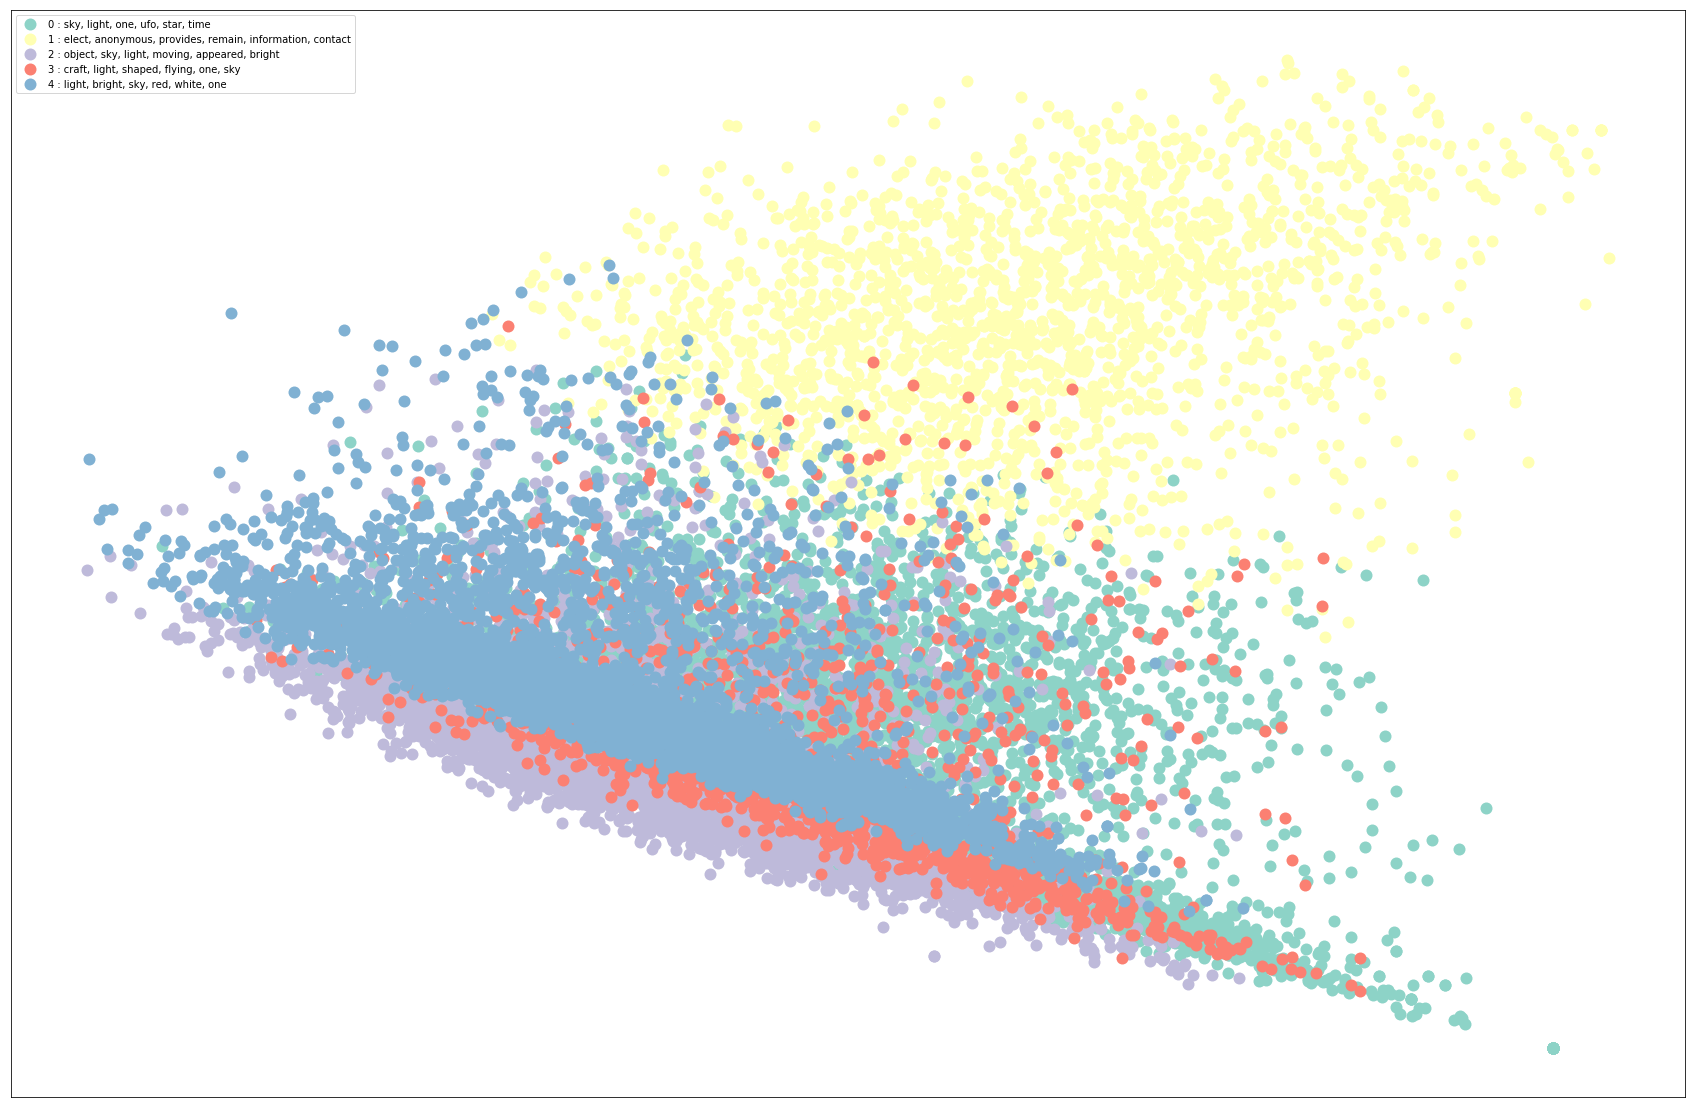

Wall time: 0 ns


In [87]:
## 2D PLOT

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=SelectStates_clusters, markers= shapes, state=encounters['state'])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(30, 20)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
  
    mk_state = group.state.values.tolist()
    
    ax.plot(group.x, group.y, marker="o", linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the state title
#for i in range(len(df)):
#    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['state'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

%time

<IPython.core.display.Javascript object>


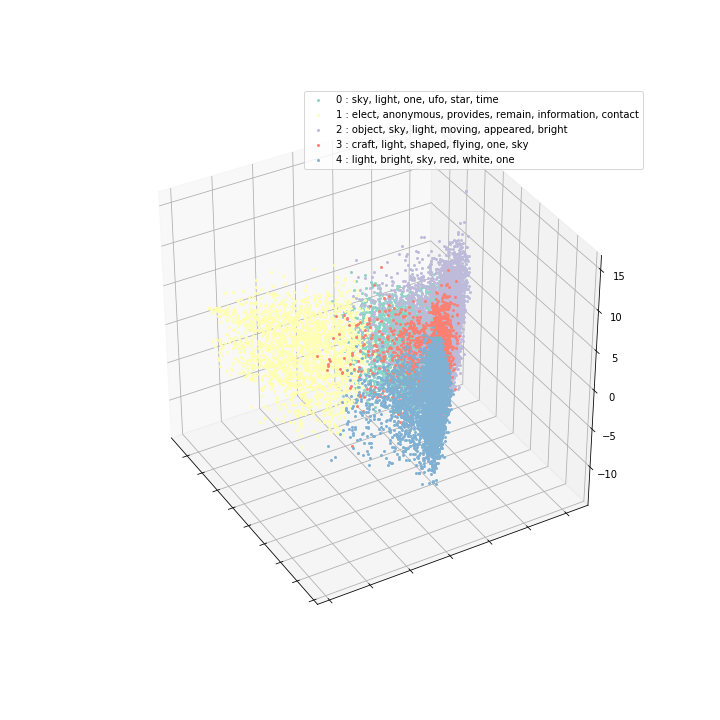

Wall time: 0 ns


In [89]:
## 3D PLOT
from mpl_toolkits.mplot3d import Axes3D

#Jupyter plot options
%matplotlib notebook
#%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=x_s, y=y_s, z=z_s, label=SelectStates_clusters, markers=shapes, state=encounters['state'])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig = plt.figure(figsize=(10,10))
#ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, group.z, marker="o", linestyle='', ms=3, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y,z position with the label as the state
#for i in range(len(df)):
#    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['z'], df.iloc[i]['state'], size=8)  

 
    

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)   

#plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

%time